<a href="https://colab.research.google.com/github/vpagonis/Python-Codes/blob/main/NWLDW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Peak Analysis of irradiated microcline

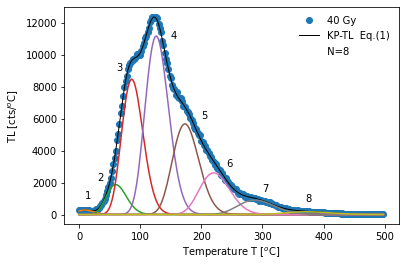

Best fit parameters: [4.58776381e+15 5.49746032e+16 4.46277761e+17 1.05548853e+18
 4.58914619e+17 7.27254952e+16 4.41920133e+15 1.28049285e+14
 6.97016483e-01 8.39999996e-01 9.24113402e-01 1.04752599e+00
 1.16517148e+00 1.24320059e+00 1.33001634e+00 1.42525364e+00
 7.06799123e+12 1.11525756e+13 1.89413241e+13 3.12029997e+13
 2.38464223e+13 7.20170194e+12 1.04919145e+12 1.29235329e+11
 1.19311756e-02]


In [5]:
#  deconvolution of microcline data after 40 Gy
#  with optimal number of peaks N=8
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable 
import warnings
warnings.filterwarnings("ignore")
import requests

# read data file from GitHub
url='https://github.com/vpagonis/Python-Codes/raw/main/data/KC40Gy.txt'
response=requests.get(url)
a=response.text
b=np.array(list(map(float,a.strip("[]").split())))
data=b.reshape(-1,2)

x_data,y_data = data[:, 0], data[:, 1] 
z,   kB =1.8, 8.617E-5

# fuction contains KP-TL equation
def TL(T, B,En , s, rho):
    return abs(B)* np.exp(-rho*( (np.log(1+z*s*kB*(((T+\
				    273)**2.0)/np.abs(En))*np.exp(-En/(kB*(T+273)))*\
				    (1-2*kB*(T+273)/En)))**3.0))*(En**2.0-6*(kB**2.0)*\
    	((T+273)**2.0))*((np.log(1+z*s*kB*(((T+273)**2.0)/\
				    abs(En))*np.exp(-En/(kB*(T+273)))*(1-2*kB*(T+273)/\
				    En)))**2.0)/(En*kB*s*((T+273)**2)*z-2*(kB**2.0)*\
				    s*z*((T+273)**3.0)+np.exp(En/(kB*(T+273)))*En)
        
# function to find the best fit parameters for N=8
def total_TL(T, *inis): 
    u=np.array([0 for i in range(len(x_data))])
    Bs, Ens,ss,rho=    inis[0:nPks], inis[nPks:2*nPks]\
		    ,inis[2*nPks:3*nPks],inis[-1]
    for i in range(nPks):
        u=u+TL(T,Bs[i],Ens[i],ss[i],rho)
    return u

nPks=8
# B=amplitudes of N=8 components (nPks=8), vary B=2e13-1e19 a.u. 
B=[2e17]*nPks
lowB, highB=[0.0001*x for x in B], [50*x for x in B]

# rho=acceptor density varies rho=0.008-0.015
lowrho, highrho, rho= [0.008,.015,.01]

# s=frequencies of N=8 components, vary s=1e11-1e14
s=[1e13]*nPks
lows, highs=[1e11 for x in s], [1e14 for x in s]

# Energy values can vary +-5% from initial rise values
En=[.73,.8, .9,1.06,1.19,1.3,1.4,1.5]
lowEn,highEn =[0.95*x for x in En],[1.05*x for x in En]

#inis contains the initial values of parameters B, En, s, rho
inis=B+En+s+[rho]
lowbnds=lowB+lowEn+lows+[lowrho]
highbnds=highB+highEn+highs+[highrho]

# find best fit parameters ad their uncetainties
params, cov = optimize.curve_fit(total_TL,x_data,y_data,p0=inis,bounds=(lowbnds,highbnds),maxfev=10000)

# plot data and sum of N=8 components
plt.plot(x_data, y_data,'o',label='40 Gy');
plt.text(400,10000,' N='+str(nPks));
plt.plot(x_data, total_TL(x_data,*params),c='black',label='KP-TL  Eq.(1)',linewidth=1); 

# plot the N=8 components
for i in range(0,nPks): 
    plt.plot(x_data, TL(x_data, params[i],params[nPks+i],\
	params[2*nPks+i],params[-1]));

leg = plt.legend();
leg.get_frame().set_linewidth(0.0);  
plt.ylabel('TL [cts/$^{o}$C]');
plt.xlabel(r'Temperature T [$^{o}$C]');
res=total_TL(x_data, *params)-y_data
FOM=100*np.sum(abs(res))/np.sum(y_data)
plt.text(10,1000,'1');
plt.text(30,2100,'2');
plt.text(60,9000,'3');
plt.text(150,11000,'4');
plt.text(200,6000,'5');
plt.text(240,3000,'6');
plt.text(300,1400,'7');
plt.text(370,800,'8');
plt.show();
print('Best fit parameters:',params)